# Marketing Expenses Optimization

In this project we will try to help optimize marketing expenses at Yandex.Afisha. To do so we are going to look at data for: 
- Visits
- Orders
- Costs

We will analyze the visits of the users, check how many users actually just visit and how many make orders; calculate the conversion rate.
We will also check how many users stay and keep ordering; retention rate.
Further on we will see from which sources our costumers come from, how much do we pay for these sources, and whether or not the return from these sources on our investment is sufficient.


## 1. Importing libraries and reading data files

In [1]:
# Importing libraries
import pandas as pd
import sys
!{sys.executable} -m pip install plotly
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import Markdown, display

In [2]:
# reading datasets and storing them into variables
try:
    visits = pd.read_csv('datasets/visits_log_us.csv',
                         dtype={'Device': 'category'},
                         parse_dates=['Start Ts', 'End Ts'])
    orders = pd.read_csv('datasets/orders_log_us.csv',
                         parse_dates=['Buy Ts'])
    costs = pd.read_csv('datasets/costs_us.csv',
                         parse_dates=['dt'])
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv',
                         dtype={'Device': 'category'},
                         parse_dates=['Start Ts', 'End Ts'])
    orders = pd.read_csv('/datasets/orders_log_us.csv',
                         parse_dates=['Buy Ts'])
    costs = pd.read_csv('/datasets/costs_us.csv',
                         parse_dates=['dt'])

We will check if the data is in the correct types

In [3]:
visits.info(memory_usage='deep')
print()
orders.info(memory_usage='deep')
print()
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 t

In [4]:
# Renaming columns names:
visits.rename(columns=lambda x: str.lower(x).replace(" ","_"), inplace=True)
orders.rename(columns=lambda x: str.lower(x).replace(" ","_"), inplace=True)
costs.rename(columns=lambda x: str.lower(x).replace(" ","_"), inplace=True)

#Check:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Data types looks ok and the memory usage is fine. Also, we do not see any null variables. let's dive into metrics

## Metrics Calculations & Reports

In this chapter we will calculate different metrics and visualize them in order to be able to evaluate the expenses.


### Product Metrics
We will start with checking how many people use the product every day, week, and month. In other words we will calculate the DAU (Daily Active Users), WAU (Weekly Active Users), and MAU (Monthly Active Users) metrics.

In [5]:
# We will check the visits database in order calculate the usage per periode
# Adding periode columns
visits['week'] = visits.start_ts.astype('datetime64[W]')
visits['month'] = visits.start_ts.astype('datetime64[M]')
visits['date'] = visits.start_ts.astype('datetime64[D]')

# Grouping by periode and aggregating user counts
mau = visits.groupby('month')['uid'].nunique().reset_index()
wau = visits.groupby('week')['uid'].nunique().reset_index()
dau = visits.groupby('date')['uid'].nunique().reset_index()

In [6]:
mau.tail()

,month,uid
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473
10,2018-04-01,21008
11,2018-05-01,20701


In [7]:
wau.tail()

,week,uid
48,2018-05-03,4140
49,2018-05-10,4692
50,2018-05-17,5234
51,2018-05-24,5609
52,2018-05-31,1997


In [8]:
dau.tail()

,date,uid
359,2018-05-27,620
360,2018-05-28,1039
361,2018-05-29,948
362,2018-05-30,1289
363,2018-05-31,1997


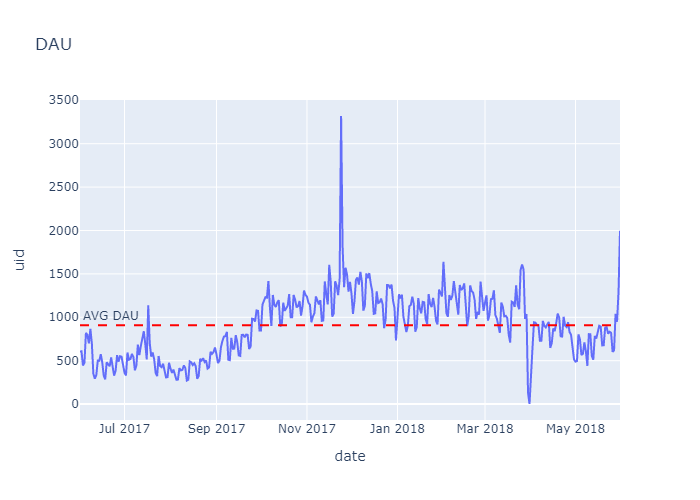

DAU AVG is 907.99


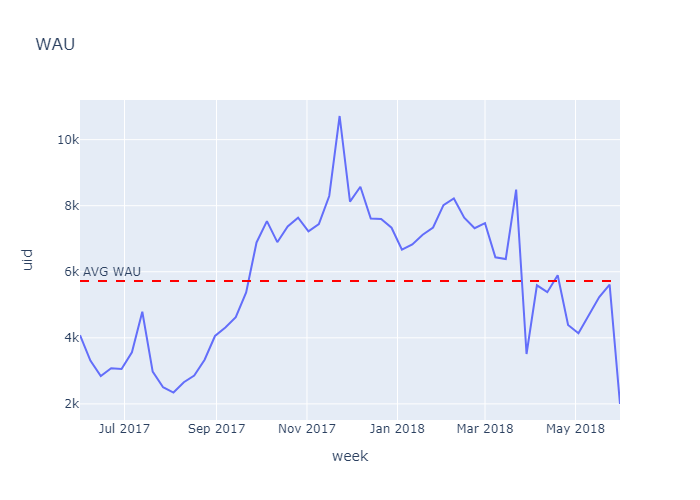

WAU AVG is 5724.42


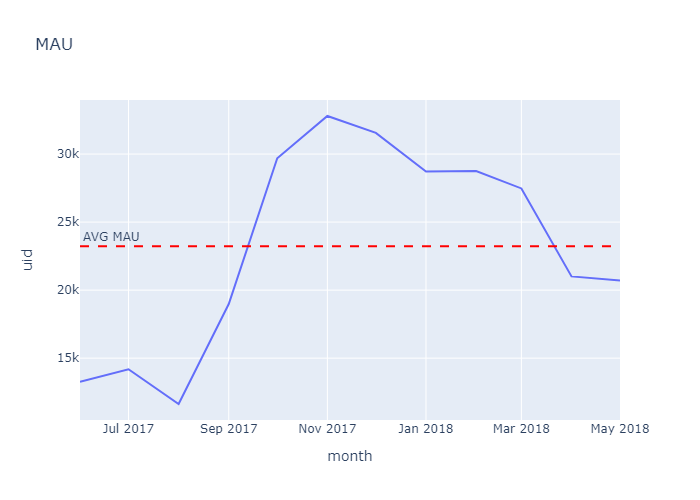

MAU AVG is 23228.42


In [60]:
# We will plot the metrics
fig = px.line(dau,x='date', y='uid', title='DAU')
fig.add_hline(y=dau['uid'].mean(),line_dash='dash',line_color='red', annotation_text='AVG DAU', annotation_position='top left')
fig.show('png')
print('DAU AVG is {:.2f}'.format(dau['uid'].mean()))
fig = px.line(wau,x='week', y='uid', title='WAU')
fig.add_hline(y=wau['uid'].mean(),line_dash='dash',line_color='red', annotation_text='AVG WAU', annotation_position='top left')
fig.show('png')
print('WAU AVG is {:.2f}'.format(wau['uid'].mean()))
fig = px.line(mau,x='month', y='uid', title='MAU')
fig.add_hline(y=mau['uid'].mean(),line_dash='dash',line_color='red', annotation_text='AVG MAU', annotation_position='top left')
fig.show('png')
print('MAU AVG is {:.2f}'.format(mau['uid'].mean()))

In the graphs above we can see the DAU, WAU, MAU respectively.
Obviously the DAU is showing the most data points since it repesents the daily amount of visits which is averaging on about 908 daily visits. We can a spike on a specific day 24/11/2017 which represents "Black Friday" of 3319 visits. We also see a negative  fall on 31.03.2018 which we can't explain at this point.
On the WAU and MAU we can see the same spikes and falls, and we can also see the seasonality in users behavior; high activity during the holidays and low activity during the summer where people spend time outsite in the sun :)


In [63]:
# Finding the number of daily sessions:
dau_sessions = visits.groupby('date')['uid'].count().reset_index()
dau_sessions
dau_sessions.head(10)

,date,uid
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893
5,2017-06-06,875
6,2017-06-07,788
7,2017-06-08,939
8,2017-06-09,755
9,2017-06-10,375


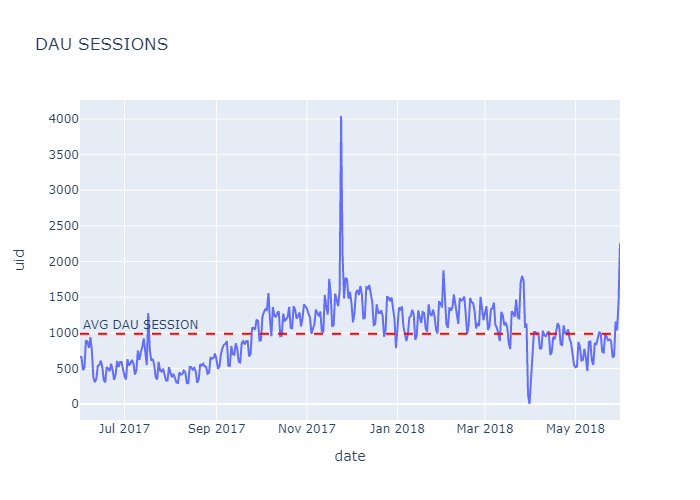

In [64]:
# Plot the daily sessions:
fig = px.line(dau_sessions,x='date', y='uid', title='DAU SESSIONS')
fig.add_hline(y=dau_sessions['uid'].mean(),line_dash='dash',line_color='red', annotation_text='AVG DAU SESSION', annotation_position='top left')
fig.show("png")

We can see the trend is similar, but the numbers are a little bit higher because each user may have more than one session.  
Let's calculate how many sessions per user we have

In [12]:
# Sessions per user
dau_sessions.columns = ['date','uid_sessions']
dau.columns = ['date','uid']
session_per_user = dau_sessions.merge(dau, on='date', how='left').reset_index()
session_per_user['session_per_user'] = session_per_user.uid_sessions / session_per_user.uid
session_per_user.session_per_user.describe().reset_index()

,index,session_per_user
0,count,364.000000
1,mean,1.082170
2,std,0.020876
3,min,1.000000
4,25%,1.070321
5,50%,1.082488
6,75%,1.093876
7,max,1.217837


**On average we have 1 session per user, sometimes a tiny little bit more but it's insignificant**

Relevant datset is 90.04% of the original dataset


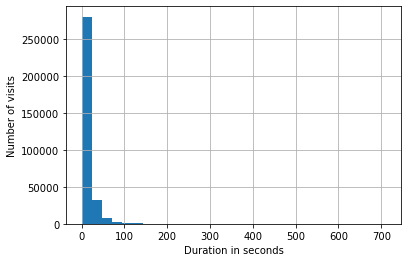

,index,duration
0,count,323604.000000
1,mean,11.902825
2,std,17.105824
3,min,0.316667
4,25%,2.000000
5,50%,6.000000
6,75%,15.000000
7,max,711.000000


In [13]:
# Caluclating the length of the sessions where the end_ts is larger than the start_ts:
visits_rel = visits.copy()
visits_rel = visits_rel[visits_rel.end_ts > visits_rel.start_ts]
visits_rel['duration'] = (visits_rel.end_ts - visits_rel.start_ts)
print('Relevant datset is {:.2%} of the original dataset'.format(len(visits_rel)/len(visits)))

# Transform into minutes and check the distributuion:
plt.xlabel('Duration in seconds')
plt.ylabel('Number of visits')
(visits_rel['duration'].dt.total_seconds()/60).hist(bins=30)
plt.show()
(visits_rel['duration'].dt.total_seconds()/60).describe().reset_index()

We can see that the median is 5 minutes, and since the distribution is skewed then the median would be more relevant than the mean value.  

We will now check the retention rate of the users


In [14]:
# Calculating the first session for each user:
visits_1st_sess = visits.groupby('uid')['date'].min().reset_index()
visits_1st_sess.columns = ['uid','first_session']
visits_1st_sess.head()

,uid,first_session
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


In [15]:
# Merge with the visit table
visits = visits.merge(visits_1st_sess, on='uid', how='inner')
visits.head()

,device,end_ts,source_id,start_ts,uid,week,month,date,first_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-14,2017-12-01,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-15,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-06-29,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-17,2018-05-01,2018-05-20,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-08,2018-03-01,2018-03-09,2018-03-09


In [16]:
visits

,device,end_ts,source_id,start_ts,uid,week,month,date,first_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-14,2017-12-01,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-15,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-06-29,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-17,2018-05-01,2018-05-20,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-08,2018-03-01,2018-03-09,2018-03-09
...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-19,2018-04-01,2018-04-23,2018-04-23
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-02,2017-11-01,2017-11-08,2017-11-08
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-27,2017-07-01,2017-07-31,2017-07-31
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-15,2018-03-01,2018-03-20,2018-03-20


In [17]:
# Cohort analysis - we will divide the users into monthly cohorts
visits['session_month'] = visits['date'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_session'].astype('datetime64[M]')

# Calculate the age of the cohorts
visits['age'] = ((pd.to_datetime(visits['session_month']) - pd.to_datetime(visits['first_session_month'])) / np.timedelta64(1,'M')).round().astype('int')

# Create a pivot table with the retention rate:
cohorts = visits.pivot_table(index='first_session_month',columns='age', values='uid', aggfunc='nunique')
cohorts.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,,
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,,,
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,,,,
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,,,,,
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,,,,,,
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,,,,,,,
2018-02-01,22197.0,1267.0,565.0,446.0,,,,,,,,


In [18]:
# Calculating the retention rate:
retention = cohorts.iloc[:,0:].div(cohorts[0], axis=0)
retention.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,,
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.03586,0.024186,0.022809,,,
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,,,,
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.0218,,,,,
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,,,,,,
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,,,,,,,
2018-02-01,1.0,0.05708,0.025454,0.020093,,,,,,,,


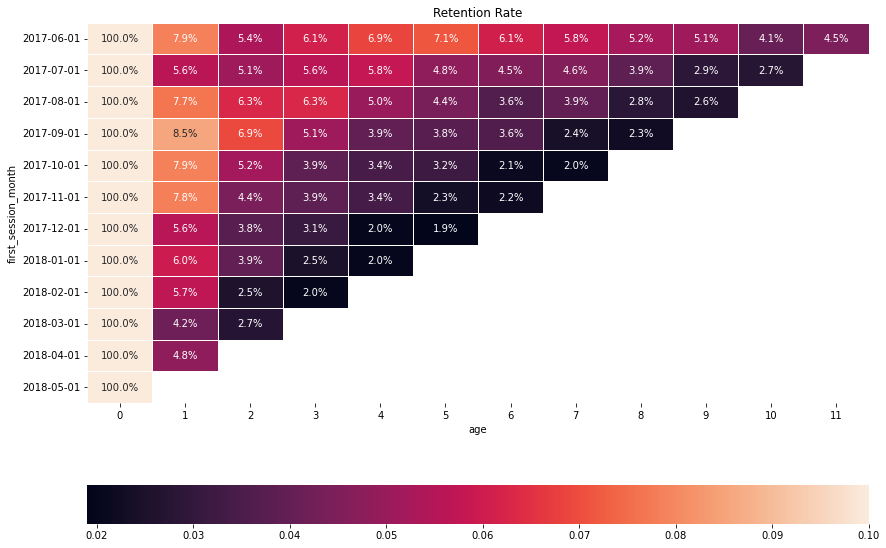

In [19]:
# Creating a heatmap:
retention.index = retention.index.astype(str)
plt.figure(figsize=(14,10))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='white', vmax=0.1, cbar_kws={'orientation':'horizontal'}).set(title='Retention Rate')
plt.show()

According to the heatmap above, the retention rate from the beginning of summer until the end of the holidays is higher than the retention rate during the first half of the year. September cohort show the most promising retention rate. it could be due to the beginning of school, and preparation for the holidays that are around the corner.


### Sales Metrics
Next we will calculate the sales metrics starting with the conversion rate:

In [20]:
# Getting the first orders and first visits:
first_order = orders.groupby('uid').buy_ts.min().reset_index()
first_visit = visits.groupby('uid').start_ts.min().reset_index()

first_order.head()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [21]:
# Merging first order and first visit
order_per_user = first_order.merge(first_visit, how='outer', on='uid')
order_per_user.head()

,uid,buy_ts,start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [22]:
# Calculating the convertion
conversion = order_per_user[order_per_user.buy_ts > order_per_user.start_ts]
order_per_user['conversion'] = conversion.buy_ts - conversion.start_ts
order_per_user[order_per_user.conversion.notna()]

,uid,buy_ts,start_ts,conversion
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,0 days 00:25:00
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,36 days 23:02:00
...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,95 days 19:33:00
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,0 days 00:07:00
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,231 days 11:03:00
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,103 days 09:33:00


count    34068.000000
mean        17.935453
std         48.398809
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        363.000000
Name: conversion, dtype: float64


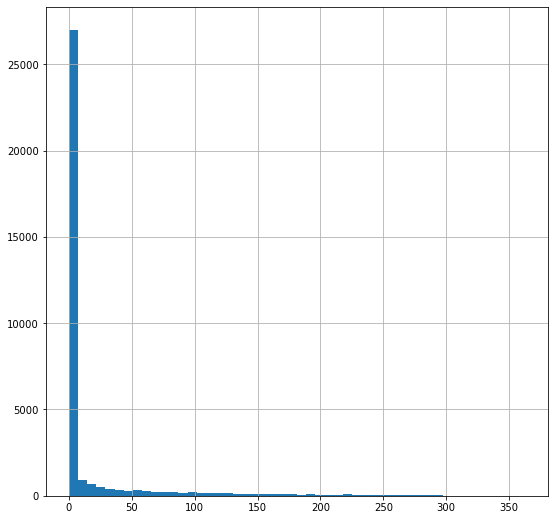

In [23]:
# Plotting a histogram for the conversion
print(order_per_user[order_per_user.conversion.notna()].conversion.dt.days.describe())
order_per_user[order_per_user.conversion.notna()].conversion.dt.days.hist(bins=50, figsize=(9,9))
plt.show()

We can say that most of the users fall into category conversion 0day. This means that they make an order in their first visit.  

After calculating the conversion, we will find out the number of purchases in a given period of time, let's say month.


In [24]:
# Defining monthly cohorts for orders:
orders_first = orders.groupby('uid').buy_ts.min().reset_index()
orders_first.columns = ['uid','first_order']
orders = orders.merge(orders_first, on='uid', how='inner')
orders.head()

,buy_ts,revenue,uid,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [25]:
# Addting first order month to orders table:
orders['first_order_month'] = orders.first_order.astype('datetime64[M]')
# Calculating cohort sizes
cohort_size= orders.groupby('first_order_month').uid.nunique().reset_index()
cohort_size.columns = ['first_order_month','cohort_size']
cohort_size.head()

,first_order_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [26]:
# Creating a month column for the orders table:
orders['month'] = pd.to_datetime(orders.buy_ts).astype('datetime64[M]')

# Creating the cohort table:
cohort = orders.groupby(['first_order_month','month']).revenue.count().reset_index()
cohort.columns = ['first_order_month','month','orders']

# Merge with cohort sizes
cohort = cohort.merge(cohort_size, on='first_order_month')
cohort['lifetime_month'] = ((cohort.month - cohort.first_order_month) / np.timedelta64(1,'M')).round()
cohort['orders_per_buyer'] = cohort.orders / cohort.cohort_size
cohort.head()

,first_order_month,month,orders,cohort_size,lifetime_month,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0.0,1.163618
1,2017-06-01,2017-07-01,177,2023,1.0,0.087494
2,2017-06-01,2017-08-01,174,2023,2.0,0.086011
3,2017-06-01,2017-09-01,226,2023,3.0,0.111715
4,2017-06-01,2017-10-01,292,2023,4.0,0.144340


In [27]:
# Creating a pivot table to see the orders per buyer in each month
cohort_pvt = cohort.pivot_table(index='first_order_month',
                                values='orders_per_buyer',
                                columns='lifetime_month',
                                aggfunc='sum'
                               )
cohort_pvt.round(2).fillna('')

lifetime_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04
2017-07-01,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,,
2017-09-01,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,,,
2017-10-01,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,,,,
2017-11-01,1.18,0.1,0.04,0.05,0.03,0.01,0.02,,,,,
2017-12-01,1.15,0.06,0.05,0.04,0.02,0.02,,,,,,
2018-01-01,1.12,0.07,0.05,0.02,0.02,,,,,,,
2018-02-01,1.12,0.06,0.02,0.02,,,,,,,,


In [28]:
# Checking the cumulative sum of the orders per buyer
cohort_pvt.cumsum(axis=1).round(2).fillna('')

lifetime_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


According to the pivot table above, we can see that the cohorts make their purchases when they register, and the number of purchases per each user diminish drastically over time.

Next we will calculate the average order price

In [29]:
# Getting the average order revenue
# Grouping by id
avg_order = orders.groupby('uid').revenue.sum().reset_index()

# Calculating the average
print('The average order revenue is {:.2f}'.format(avg_order.revenue.mean()))

The average order revenue is 6.90


In order to calculate how much money the cohorts bring, we will calculate the LTV

In [30]:
# Calculate the revenue per cohort in each month:
cohort_ltv = orders.groupby(['first_order_month','month']).revenue.sum().reset_index()
cohort_ltv.columns = ['first_order_month','month','revenue']
margin_rate = 1

# Merge with cohort size
cohort_ltv = cohort_ltv.merge(cohort_size,on='first_order_month')
cohort_ltv['lifetime'] = ((cohort_ltv.month - cohort_ltv.first_order_month)/np.timedelta64(1,'M')).round()
cohort_ltv['ltv'] = margin_rate * cohort_ltv.revenue / cohort_ltv.cohort_size
cohort_ltv

,first_order_month,month,revenue,cohort_size,lifetime,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2.0,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0.0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1.0,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0.0,4.660562


In [31]:
# Creating a pivot table
cohort_ltv_pvt = cohort_ltv.pivot_table(index='first_order_month',
                                        columns='lifetime',
                                        values='ltv',
                                        aggfunc='sum'
                                       )
cohort_ltv_pvt.cumsum(axis=1).fillna('')

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.64738,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.96896,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.23118,8.386854,
2017-08-01,5.276518,5.748511,6.206993,6.59827,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,,
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.25122,13.435227,,,
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,,,,
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,,,,,
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,,,,,,
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,,,,,,,
2018-02-01,4.156987,4.435262,4.513777,4.587921,,,,,,,,


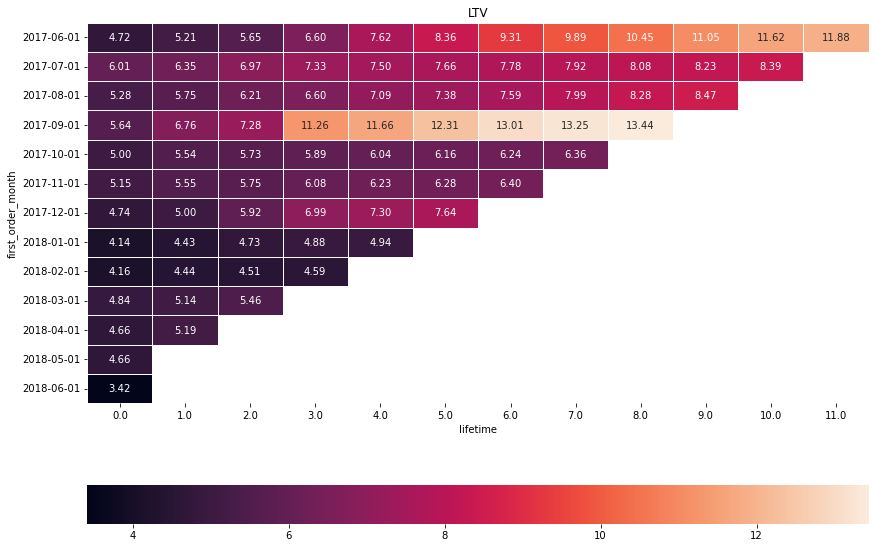

In [32]:
cohort_ltv_pvt.index = cohort_ltv_pvt.index.astype(str)
plt.figure(figsize=(14,10))
sns.heatmap(cohort_ltv_pvt.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='white', cbar_kws={'orientation':'horizontal'}).set(title='LTV')
plt.show()

In the heatmap above we can see that LTV is rising dramatically on November, same peak we saw on the DAU graph on 24/11/2017 - black friday. Also, cyber monday was on 27/11/2017 and both of them are followed by the holidays which could explain the spikes in revenues.


### Marketing Metrics
Next we will calculate the marketing costs and how much money was spent

In [33]:
# Calculating overall marketing cost:
print('Overall marketing cost is {}'.format(costs.costs.sum()))


Overall marketing cost is 329131.62


In [34]:
# Calculating cost per source
cost_per_source = costs.groupby('source_id').costs.sum().reset_index()
cost_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [35]:
# Calculating costs over time
cost_over_time = costs.groupby(['dt']).costs.sum().reset_index()
cost_over_time.head()

,dt,costs
0,2017-06-01,735.26
1,2017-06-02,721.19
2,2017-06-03,450.85
3,2017-06-04,761.16
4,2017-06-05,821.44


This doesn't help much, we will plot the cost over time

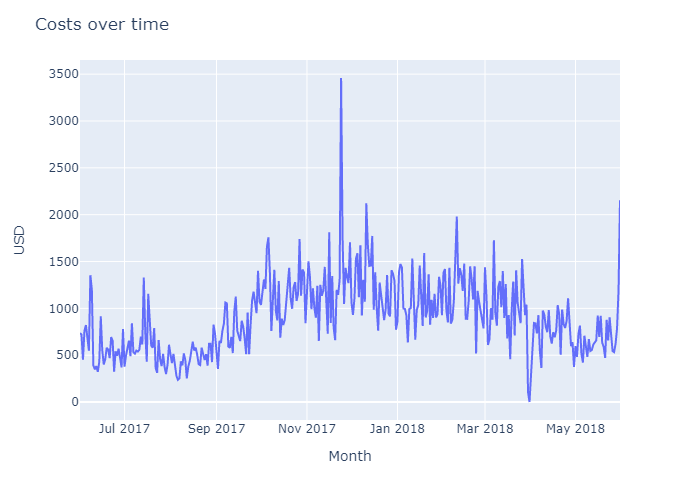

In [65]:
# Generating a line plot of total cost over time
fig = px.line(cost_over_time, x='dt', y='costs',
             labels={"dt":"Month","costs":"USD"})
fig.update_layout(title='Costs over time')
fig.show('png')

In [37]:
# Generating a line plot of total cost over time per source
fig = px.line(costs, x='dt', y='costs', color='source_id',
             labels={"dt":"Month","costs":"USD"})
fig.update_layout(title='Cost per source over time')
fig.show()

We can see that source 3 is the most expensive one followed by source 4. In general, the expenses have the same trend with the same peak on November 24th, 2017. Also it looks very similar to DAU.
Let's investigate further...

In [38]:
# We will find the cost by month
costs['cost_month'] = costs.dt.astype('datetime64[M]')

# Group by month and summing
cost_by_month = costs.groupby('cost_month').costs.sum().reset_index()
cost_by_month.head()

,cost_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [39]:
# We will now check how many buyers the marketing costs brought us
clients_per_month = orders.groupby(['first_order_month']).uid.nunique().reset_index()
clients_per_month.columns =['cost_month','clients']
clients_per_month.head()

,cost_month,clients
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [40]:
# Merging the tables and calculating CAC
cac_per_month = cost_by_month.merge(clients_per_month, on='cost_month', how='outer')
cac_per_month['cac'] = cac_per_month.costs/cac_per_month.clients
cac_per_month.head()

,cost_month,costs,clients,cac
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327


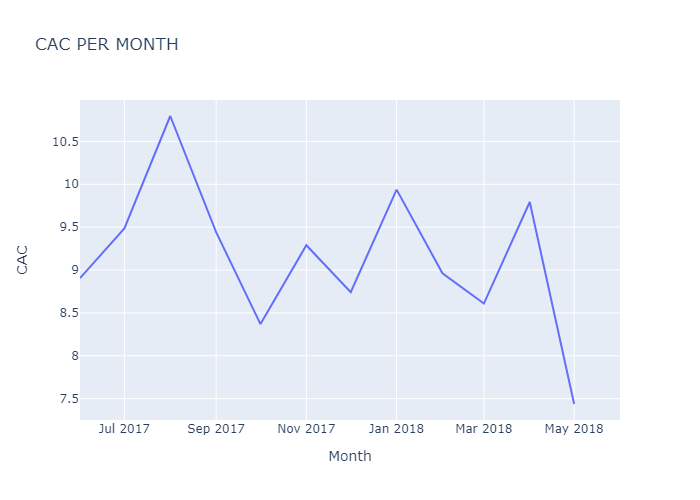

In [66]:
# Plotting a graph to visualize the CAC:
fig = px.line(cac_per_month, x='cost_month', y='cac', title='CAC PER MONTH',
              labels={"cost_month":"Month","cac":"CAC"})
fig.show('png')

**In order to calculate CAC per source, we will assume that the first source (in the visits) is the relevant source.**

In [42]:
# Getting the first source for each user:
first_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()
first_source.columns =['uid','first_source']
first_source.head()

,uid,first_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [43]:
# Merge to orders
orders = orders.merge(first_source, on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,first_order,first_order_month,month,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,3


In [44]:
# Calculating the costs per month per source
costs_per_month_source = costs.groupby(['cost_month','source_id']).costs.sum().reset_index()
costs_per_month_source.head()

,cost_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [45]:
# Calculating buyers per month per source
orders_per_month_source = orders.groupby(['first_order_month','first_source']).uid.nunique().reset_index()
orders_per_month_source.columns = ['cost_month','source_id','clients']
orders_per_month_source.head()

,cost_month,source_id,clients
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [46]:
# Merging the tables in order to calculate CAC per month per source:
cac_month_source = costs_per_month_source.merge(orders_per_month_source,on=['cost_month','source_id'],how='left')
cac_month_source['cac'] = cac_month_source.costs / cac_month_source.clients
cac_month_source.head()

,cost_month,source_id,costs,clients,cac
0,2017-06-01,1,1125.61,190,5.924263
1,2017-06-01,2,2427.38,235,10.329277
2,2017-06-01,3,7731.65,638,12.118574
3,2017-06-01,4,3514.80,413,8.510412
4,2017-06-01,5,2616.12,384,6.812812


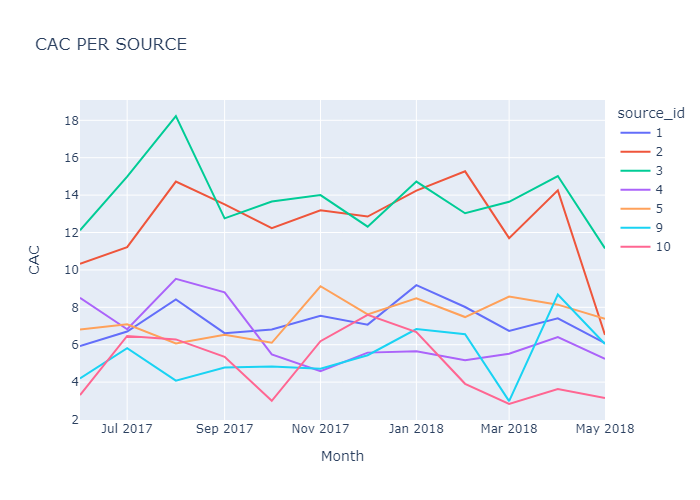

In [67]:
# Plotting grath to visualize better
fig = px.line(cac_month_source, x='cost_month', y='cac', color='source_id', title='CAC PER SOURCE',
              labels={"cost_month":"Month","cac":"CAC"})
fig.show('png')

In [48]:
# CAC total per source
cac_month_source.groupby('source_id').cac.sum().sort_values(ascending=False).reset_index()

,source_id,cac
0,3,165.632917
1,2,150.048815
2,5,89.423257
3,1,86.545286
4,4,77.272488
5,9,64.966699
6,10,58.405501


According to the graph above, we can see that sources number 2 and 3 are the most expensive ones. We will calculate ROI in order to see if they actually worth it

In [49]:
# Calculating ROI
cac_per_month_roi= cac_per_month[['cost_month','cac']]
cac_per_month_roi.columns = ['first_order_month','cac']
roi = cohort_ltv.merge(cac_per_month_roi, on='first_order_month', how='left')
roi['roi'] = roi.ltv / roi.cac
roi.head()

,first_order_month,month,revenue,cohort_size,lifetime,ltv,cac,roi
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091,0.054500
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091,0.049145
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091,0.107205
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091,0.114825


In [50]:
# Creating pivot table for ROI:
roi_pvt = roi.pivot_table(index='first_order_month',
                          values='roi',
                          columns='lifetime',
                          aggfunc='mean'
                         )
roi_pvt.cumsum(axis=1).round(2).fillna("")

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


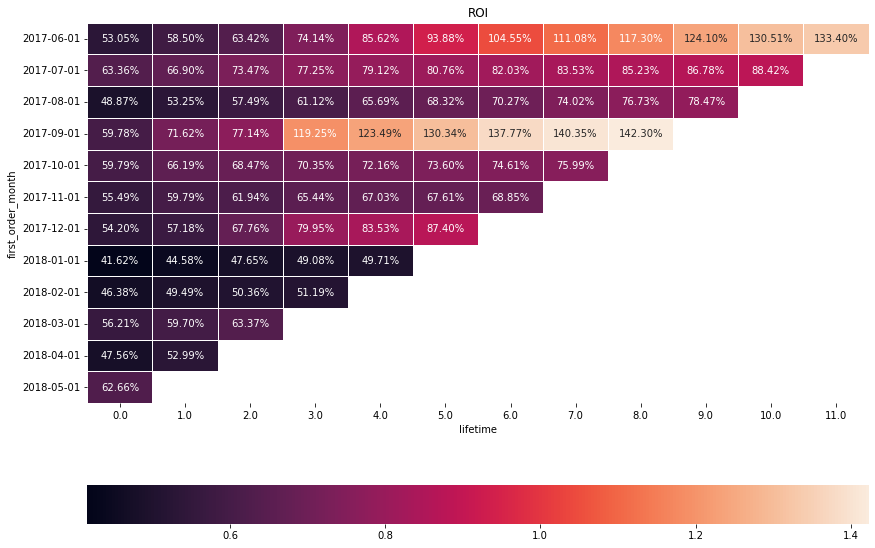

In [51]:
# Plotting heatmap:
roi_pvt.index = roi_pvt.index.astype(str)
plt.figure(figsize=(14,10))
sns.heatmap(roi_pvt.cumsum(axis=1), annot=True, fmt='.2%', linewidths=1, linecolor='white', cbar_kws={'orientation':'horizontal'}).set(title='ROI')
plt.show()

Next we will calculate ROI per source in order to finally determine if it's worth the expenses

In [52]:
# Calculating LTV per source:
ltv_source = orders.groupby('first_source')['uid','revenue'].agg({'uid':'nunique','revenue':'sum'}).reset_index()
ltv_source.columns =['source_id','clients','revenue']
ltv_source['ltv'] = ltv_source.revenue / ltv_source.clients
ltv_source.head()

C:\Users\shady\AppData\Local\Temp/ipykernel_24348/2201001329.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,source_id,clients,revenue,ltv
0,1,2899,31090.55,10.724577
1,2,3506,46923.61,13.383802
2,3,10473,54511.24,5.204931
3,4,10296,56696.83,5.506685
4,5,6931,52624.02,7.592558


In [53]:
# Calculating cost per source
cost_per_source = costs.groupby(['source_id']).costs.sum().reset_index()

# Merging tables to calculate ROI per source
roi_source = cost_per_source.merge(ltv_source, on='source_id')
roi_source['cac'] = roi_source.costs / roi_source.clients
roi_source['roi'] = roi_source.ltv / roi_source.cac
roi_source.head()

,source_id,costs,clients,revenue,ltv,cac,roi
0,1,20833.27,2899,31090.55,10.724577,7.186364,1.492351
1,2,42806.04,3506,46923.61,13.383802,12.209367,1.096191
2,3,141321.63,10473,54511.24,5.204931,13.493901,0.385725
3,4,61073.60,10296,56696.83,5.506685,5.931779,0.928336
4,5,51757.10,6931,52624.02,7.592558,7.467479,1.016750


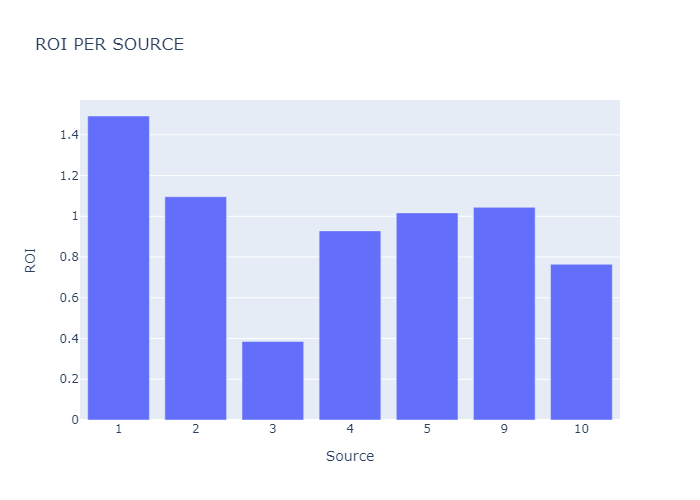

In [68]:
# Plotting a bar plot for visualization
fig = px.bar(roi_source, x='source_id', y='roi', title='ROI PER SOURCE', labels={"roi":"ROI","source_id":"Source"})
fig.update_xaxes(type='category')
fig.show('png')

We can see according to the graph that source number 3 has the lowest ROI while being the most expensive. clearly we can let go of it, maybe it's better to spend the money on source 1.

In [55]:
# Grouping the visits per source per device
device_grp = visits.groupby(['device','source_id']).uid.nunique().reset_index()
device_grp.head()

,device,source_id,uid
0,desktop,1,13172
1,desktop,2,18257
2,desktop,3,57420
3,desktop,4,55607
4,desktop,5,42053


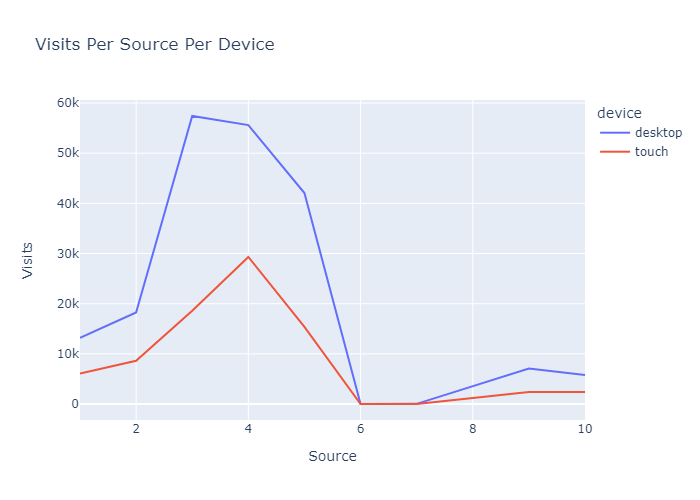

In [69]:
# Plotting a graph to visualize
fig = px.line(device_grp, x='source_id', y='uid', color='device', title='Visits Per Source Per Device',labels={"source_id":"Source","uid":"Visits"})
fig.show('png')

We can see that source number 3 brings alot of visits on desktop, but clearly they dont make enough purchases since the ROI is the lowest as we saw earlier.
Let's check how the orders are distributed between the platforms.

In [57]:
# Creating table with uid, source, and revenue
uid_source_revenue = orders[['uid','first_source','revenue']]
# Creating table with uid and devices
uid_device = visits[['uid','device']]
# Merging tables 
device_source_revenue = uid_source_revenue.merge(uid_device, on='uid', how='left')
# Grouping and aggregating
grp = device_source_revenue.groupby(['device','first_source']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
grp.head()

,device,first_source,uid,revenue
0,desktop,1,2343,1857396.78
1,desktop,2,2840,2081843.37
2,desktop,3,9107,268736.07
3,desktop,4,8360,592223.92
4,desktop,5,5905,1591465.19


In [58]:
# Total revenue per device
device_source_revenue.groupby('device')['revenue'].sum().reset_index()

,device,revenue
0,desktop,6447893.99
1,touch,514313.36


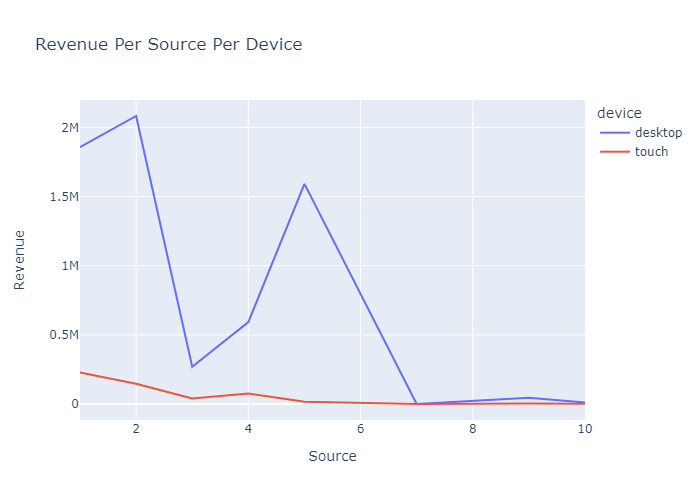

In [70]:
# Plotting the revenue per device per source graph
fig = px.line(grp, x='first_source', y='revenue', color='device', title='Revenue Per Source Per Device',labels={"first_source":"Source","revenue":"Revenue"})
fig.show('png')

Although source 3 has the most amount on visits on desktop, it bring the least amount of revenue.

# Conclusions

**According to the business analysis above which included the calculation of:**

**1. In terms of the product:**
- Daily, weekly and monthly active users
- The duration of the visits
- The retention rate

**2. In terms of orders:**
- Conversion rate
- The amount of order for a given amount of time
- The average purchase size
- Lifetime value

**3. In terms of marketing:**
- Overall costs
- Costs over time per source/device
- Cost of costumers aquisition
- Return of investment per source

**Based on the analysis, we can conclude the following:**

1. Desktop platform brings more visits and more revenue:
   Dekstops bring around 6447894 and Touch devices bring 514313
   

2. Source number 3 costs the most and bring the least, its costumer acquisition cost is the 165 in total and the return on investment is 0.38. 


3. Source number 4 bring a lot of visits, but not alot revenue specially in the touch platforms - the conversion rate is low, maybe the checkout proccess have some issues.


4. Sources 3, 4 and 6 have ROI smaller than one and shall be reconsidered.


5. Source number 1 have the highest ROI and shall be kept.


6. Almost all users make their order within the first day of registration. they don't stay longer after that. The retention rate is about 7% in the foloowing month and then it drop very quickly.


7. Users tend to make purchases the seconf half of the year, from June to December. We can see a special peak on Black Friday (24/11/217).


8. Spectember cohort is leading in terms of LTV. June also is showing a nice LTV performance and it is the oldest cohort in the dataset.

